In [2]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers import LSTM, LeakyReLU, Dropout, Input, Dense, Conv1D
from keras.models import Model
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
import numpy as np

In [9]:
df = pd.read_csv('rutland_df2.csv')

In [10]:
for date in range(len(df['datetime'])):
        datetime =  df['datetime'][date]
        year = str(datetime[:4])
        month = str(datetime[5:7])
        day = str(datetime[8:10])
        hour = str(datetime[11:13])
        final_datetime = year + month + day + hour
        df['datetime'][date] = final_datetime
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y%m%d%H')
print('datetimes converted')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


datetimes converted


In [11]:
df = df.drop(['Unnamed: 0'], axis=1)
    #df = df.drop(['0'], axis=1)

# sets index to datetime
df = df.reset_index(drop=True)
df = df.set_index(['datetime'])

    # sets input to features
df_input = df[['lmp', 'loadMw','genMw', 'temp', 'wspd', 'visibility', 'precip', 'humidity', 'lat', 'lon', 'snow', 'snowdepth', 'dew', 'pressure']]


    #nan_rows = [index for index, row in pressure_df.iterrows() if row.isnull().any()]
    #null_array = pd.isnull(pressure_df).any().nonzero()[0]
    #print(null_array)
df_input['pressure'] = df_input['pressure'].fillna(df_input['pressure'].rolling(window=8, center=True, closed='both', min_periods=1).mean())
    #df_input['pressure'] = df_input['pressure'].fillna(df_input['pressure'].median())
df_input['snow'] = df_input['snow'].fillna(df_input['snow'].rolling(window=48, center=True, closed='both', min_periods=1).mean())
df_input['snowdepth'] = df_input['snowdepth'].fillna(df_input['snowdepth'].rolling(window=48, center=True, closed='both', min_periods=1).mean())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

In [12]:
df_target = df_input[['lmp']]
df_feat = df_input[['loadMw','genMw', 'temp', 'wspd', 'visibility', 'precip', 'humidity', 'lat', 'lon', 'dew', 'pressure', 'snow', 'snowdepth']]
scaler = MinMaxScaler()
scaler = scaler.fit(df_feat)

    # transforms into numpy array for model
featMat = scaler.transform(df_feat)
    
scaler = MinMaxScaler()
scaler = scaler.fit(df_target)

    # transforms into numpy array for model
targetMat = scaler.transform(df_target)
    #print(data_normalized)
    
    # create y or target array
    #featMat = data_normalized
    #targetMat = data_normalized[:, 0]  #[:, :1]
x_train, y_train = [], []

for i in range(48, len(featMat) - 24):
  
  x_train.append(featMat[i-48:i])
  y_train.append(targetMat[i+24])
    
x_train, y_train = np.array([x_train]), np.array([y_train])
print(x_train.shape, y_train.shape)   
    #print(x_train[0][0][1][1])
x_train, y_train = np.reshape(x_train, (56784, 48, 13)), np.reshape(y_train, (56784))
print(x_train.shape, y_train.shape)   
x_train, y_train = x_train[:int(len(x_train) * 0.65)], y_train[:int(len(x_train) * 0.65)]
x_test, y_test = x_train[int(len(x_train) * 0.65):], y_train[int(len(x_train) * 0.65):]
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(1, 56784, 48, 13) (1, 56784, 1)
(56784, 48, 13) (56784,)
(36909, 48, 13) (36909,)
(12919, 48, 13) (12919,)


In [13]:
inputs = Input(shape=(48, 13))
  
    #extracts features with convolutional layers
conv1 = Conv1D(256, kernel_size=10, activation='ReLU', strides=1)(inputs)
convDrop = Dropout(0.2)(conv1)

conv2 = Conv1D(128, kernel_size=9, activation='ReLU', strides=1)(convDrop)
convDrop = Dropout(0.25)(conv2)


    #lstm layers for timeseries forecasting
Lstm = LSTM(128, activation='tanh', return_sequences=True)(convDrop)

Lstm = LSTM(64, activation='tanh')(Lstm)
lstmDrop = Dropout(0.3)(Lstm)

outputs = Dense(1, activation='linear')(lstmDrop)
model = Model(inputs, outputs)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 13)]          0         
                                                                 
 conv1d (Conv1D)             (None, 39, 256)           33536     
                                                                 
 dropout (Dropout)           (None, 39, 256)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 31, 128)           295040    
                                                                 
 dropout_1 (Dropout)         (None, 31, 128)           0         
                                                                 
 lstm (LSTM)                 (None, 31, 128)           131584    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408 

In [14]:
model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(learning_rate=0.00001),
                metrics=[tf.metrics.MeanAbsoluteError()])

history = model.fit(x=x_train,y=y_train,batch_size=50, validation_data=(x_test,y_test),validation_batch_size=50, epochs=20, shuffle=True)
    

Epoch 1/20
739/739 [==============================] - 151s 195ms/step - loss: 0.0044 - mean_absolute_error: 0.0455 - val_loss: 0.0026 - val_mean_absolute_error: 0.0321
Epoch 2/20
739/739 [==============================] - 142s 192ms/step - loss: 0.0031 - mean_absolute_error: 0.0381 - val_loss: 0.0024 - val_mean_absolute_error: 0.0300
Epoch 3/20
739/739 [==============================] - 143s 194ms/step - loss: 0.0029 - mean_absolute_error: 0.0365 - val_loss: 0.0024 - val_mean_absolute_error: 0.0297
Epoch 4/20
739/739 [==============================] - 142s 193ms/step - loss: 0.0028 - mean_absolute_error: 0.0358 - val_loss: 0.0023 - val_mean_absolute_error: 0.0292
Epoch 5/20
739/739 [==============================] - 144s 194ms/step - loss: 0.0027 - mean_absolute_error: 0.0351 - val_loss: 0.0023 - val_mean_absolute_error: 0.0290
Epoch 6/20
739/739 [==============================] - 143s 194ms/step - loss: 0.0027 - mean_absolute_error: 0.0346 - val_loss: 0.0022 - val_mean_absolute_error:

In [22]:
prediction = model.predict(x_test)

12919 1
    prediction  actual
0    23.676998   27.13
1    24.898426   27.02
2    25.972216   29.10
3    26.948612   31.73
4    27.222862   31.47
5    27.191484   34.39
6    26.549768   33.99
7    25.444157   27.74
8    23.994993   21.98
9    22.638807   21.96
10   21.704388   17.48
11   21.039627   17.56
12   20.687498   17.10
13   20.769386   13.96
14   21.296928   17.08
15   22.280752   18.52
16   23.491447   22.79
17   24.560369   26.25
18   25.403555   19.60
19   25.937641   22.96
20   26.039448   25.12
21   26.005066   25.16
22   26.053591   27.26
23   26.343132   29.74
24   26.944002   30.91
25   27.817514   37.09
26   28.755249   42.25
27   29.307369   41.36
28   29.199791   38.19
29   28.518263   40.02
30   27.263285   37.75
31   25.518028   28.97
32   23.550694   24.24
33   21.481878   24.93
34   19.485374   18.40
35   17.655832   16.96
36   16.292412   11.96
37   15.600884   11.26
38   15.687436   11.54
39   16.435495   18.38
40   17.680887   23.92
41   19.133097   26.42
42 

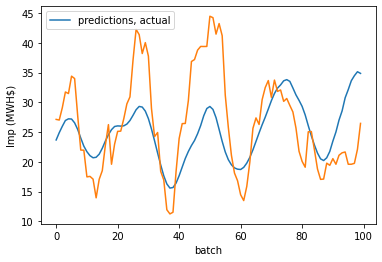

In [23]:
actual = y_test
actual = np.reshape(actual, (len(actual), 1))
prediction = np.reshape(prediction, (1, len(prediction)))
print(len(actual), len(prediction))
prediction, actual = scaler.inverse_transform(prediction), scaler.inverse_transform(actual)
prediction = prediction.flatten()
actual = actual.flatten()
results = pd.DataFrame(data={'prediction': prediction, 'actual': actual})
print(results.head(48))

plt.plot(results['prediction'][:100])
plt.plot(results['actual'][:100])
plt.legend(['predictions, actual'], loc='upper left')
plt.ylabel('lmp (MWH$)')
plt.xlabel('batch')
plt.show()

# New Section